In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Nike_Sales_Uncleaned.csv")
df.head()

df.shape
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order_ID          2500 non-null   int64  
 1   Gender_Category   2500 non-null   object 
 2   Product_Line      2500 non-null   object 
 3   Product_Name      2500 non-null   object 
 4   Size              1990 non-null   object 
 5   Units_Sold        1265 non-null   float64
 6   MRP               1246 non-null   float64
 7   Discount_Applied  832 non-null    float64
 8   Revenue           2500 non-null   float64
 9   Order_Date        1884 non-null   object 
 10  Sales_Channel     2500 non-null   object 
 11  Region            2500 non-null   object 
 12  Profit            2500 non-null   float64
dtypes: float64(5), int64(1), object(7)
memory usage: 254.0+ KB


,0
Order_ID,0
Gender_Category,0
Product_Line,0
Product_Name,0
Size,510
Units_Sold,1235
MRP,1254
Discount_Applied,1668
Revenue,0
Order_Date,616


In [19]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['units_sold'] = df['units_sold'].fillna(df['units_sold'].median())
df['mrp'] = df.groupby('product_name')['mrp'].transform(lambda x: x.fillna(x.median()))
df['discount_applied'] = df['discount_applied'].fillna(0)

df['size'] = df['size'].astype(str).str.strip()
df['size'] = df['size'].replace(['nan', 'None', ''], np.nan)

df = df.dropna(subset=['order_date'])



In [22]:
df['discount_rate'] = df['discount_applied']
df['expected_revenue'] = df['mrp'] * df['units_sold']
df['revenue_gap'] = df['expected_revenue'] - df['revenue']
df['profit_margin'] = df['profit'] / df['revenue']
df['profit_margin'] = df['profit_margin'].replace([np.inf, -np.inf], 0)
df['loss_flag'] = np.where(df['profit'] < 0, 'Loss', 'Profit')

df['month'] = df['order_date'].dt.month
df['year'] = df['order_date'].dt.year

def size_to_apparel(size):
    size = str(size).strip()

    if size in ['S', 'M', 'L', 'XL']:
        return size

    try:
        size = float(size)
        if size <= 7:
            return 'S'
        elif size <= 9:
            return 'M'
        elif size <= 11:
            return 'L'
        else:
            return 'XL'
    except:
        return None

df['size_apparel'] = df['size'].apply(size_to_apparel)


In [24]:
total_revenue = df['revenue'].sum()
total_profit = df['profit'].sum()
loss_orders = df[df['profit'] < 0].shape[0]

print(total_revenue, total_profit, loss_orders)


134534.09999999998 840644.25 140


In [25]:
channel_summary = df.groupby('sales_channel').agg(
    total_revenue=('revenue', 'sum'),
    total_profit=('profit', 'sum'),
    loss_orders=('profit', lambda x: (x < 0).sum())
).reset_index()

print(channel_summary)


  sales_channel  total_revenue  total_profit  loss_orders
0        Online       71370.31     396284.67           77
1        Retail       63163.79     444359.58           63


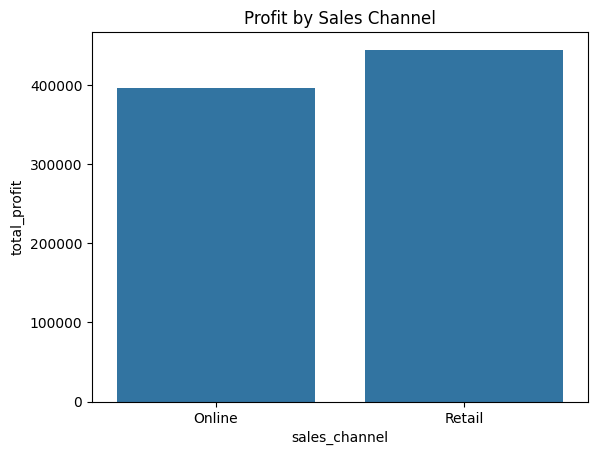

In [26]:
sns.barplot(data=channel_summary, x='sales_channel', y='total_profit')
plt.title("Profit by Sales Channel")
plt.show()


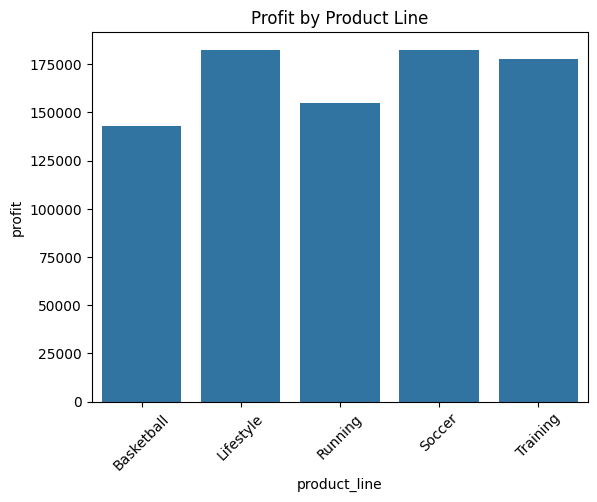

In [27]:
product_profit = df.groupby('product_line')['profit'].sum().reset_index()

sns.barplot(data=product_profit, x='product_line', y='profit')
plt.xticks(rotation=45)
plt.title("Profit by Product Line")
plt.show()


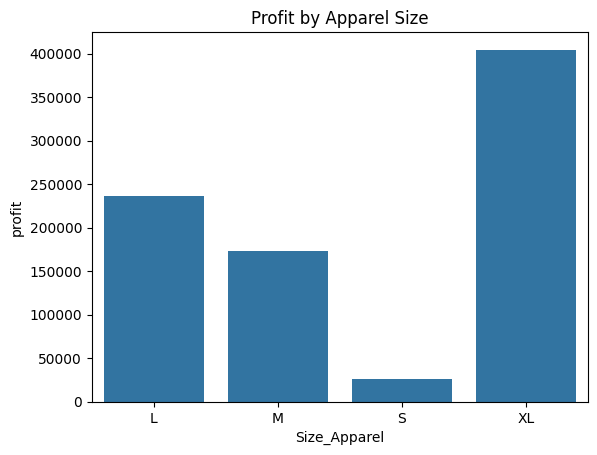

In [28]:
size_profit = df.groupby('Size_Apparel')['profit'].sum().reset_index()

sns.barplot(data=size_profit, x='Size_Apparel', y='profit')
plt.title("Profit by Apparel Size")
plt.show()


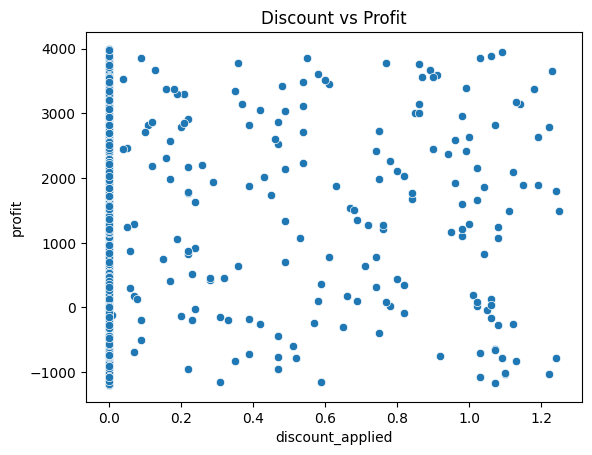

In [29]:
sns.scatterplot(data=df, x='discount_applied', y='profit')
plt.title("Discount vs Profit")
plt.show()


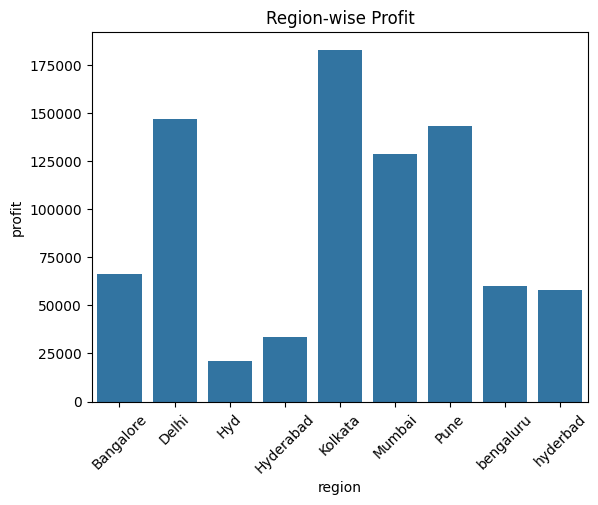

In [30]:
region_profit = df.groupby('region')['profit'].sum().reset_index()

sns.barplot(data=region_profit, x='region', y='profit')
plt.xticks(rotation=45)
plt.title("Region-wise Profit")
plt.show()


In [31]:
loss_products = df[df['profit'] < 0] \
    .groupby('product_name')['profit'] \
    .sum() \
    .sort_values() \
    .reset_index()

loss_products.head(10)


,product_name,profit
0,Phantom GT,-6827.32
1,Free RN,-6635.38
2,Tiempo Legend,-6287.74
3,Zoom Freak,-6260.71
4,Waffle One,-6127.51
5,Kyrie Flytrap,-5559.47
6,Blazer Mid,-4796.86
7,Air Zoom,-4325.69
8,React Infinity,-4187.11
9,ZoomX Invincible,-3768.86


In [37]:
df.to_csv("Nike_Sales_Cleaned.csv",index=False)